# **This was an inital playground. Please ignore**

# Hello
Let's crunch some data!

In [303]:
import sqlite3
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import abline_plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import SplineTransformer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import model_fit

Connect to DB an retrieve data

In [331]:
# Connect to SQLite DB
with sqlite3.connect("../raw data/TestDB") as con:

    # SQL query to select columns with numerical values
    # for fully informative data records
    # use total claim or not?
    qry = """SELECT ClaimNb, Exposure, VehPower, VehAge, DrivAge, BonusMalus, Density, VehBrand, Region, COALESCE(ClaimAmount, 0) AS TotalClaimAmount
    FROM FREMTPL2FREQ
    LEFT JOIN FREMTPL2SEV
    ON IDpol = IDpol2
    WHERE ClaimNb = 0 OR IDpol2 IS NOT NULL
    GROUP BY IDpol"""

    # Execute SQL query and cast query table into Pandas DataFrame
    df = pd.read_sql_query(qry, con)


In [295]:
df

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,VehBrand,Region,TotalClaimAmount
0,1,7,1,61,50,27000,'B12','R11',303.00
1,1,12,5,50,60,56,'B12','R25',1981.84
2,1,4,0,36,85,4792,'B12','R11',1456.55
3,2,10,0,51,100,27000,'B12','R11',989.64
4,1,5,0,45,50,12,'B12','R73',3986.67
...,...,...,...,...,...,...,...,...,...
668892,0,4,0,54,50,3317,'B12','R93',0.00
668893,0,4,0,41,95,9850,'B12','R11',0.00
668894,0,6,2,45,50,1323,'B12','R82',0.00
668895,0,4,0,60,50,95,'B12','R26',0.00


['ClaimNb' 'VehPower' 'VehAge' 'DrivAge' 'BonusMalus' 'Density'
 'TotalClaimAmount']


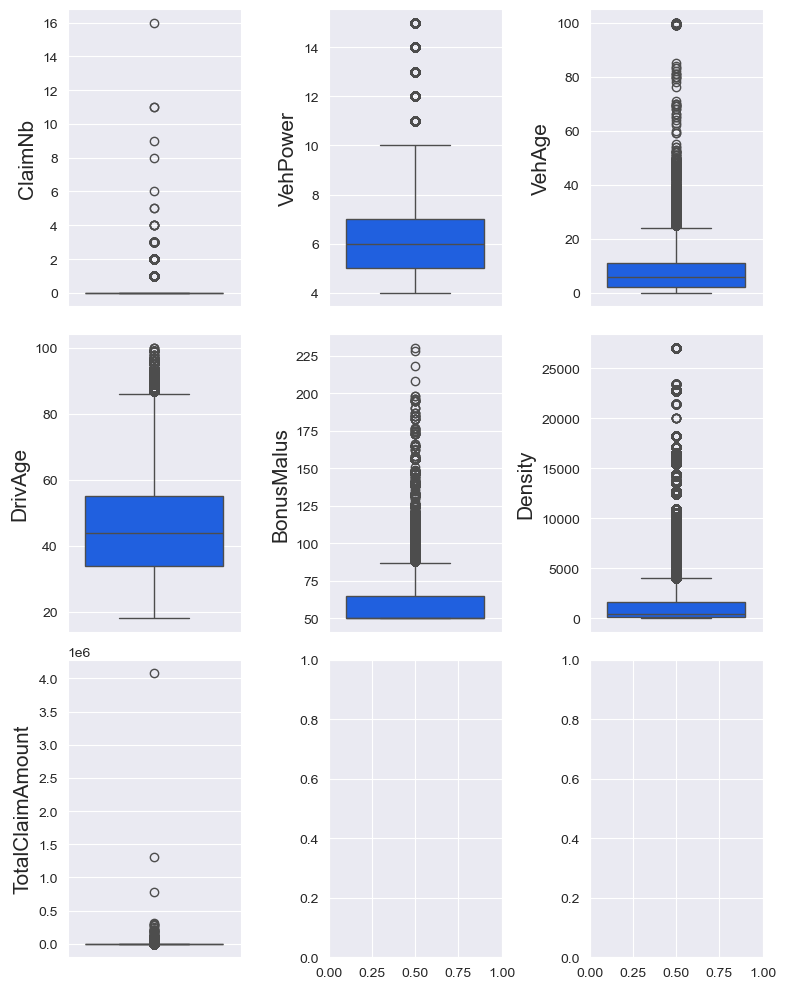

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,TotalClaimAmount
count,668897.000000,668897.000000,668897.000000,668897.000000,668897.000000,668897.000000,6.688970e+05
mean,0.039535,6.456946,7.084602,45.447846,59.784367,1790.705328,7.856946e+01
std,0.208533,2.052244,5.663181,14.119466,15.641503,3949.352296,5.534179e+03
min,0.000000,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,0.000000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,0.000000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,0.000000,7.000000,11.000000,55.000000,65.000000,1658.000000,0.000000e+00
max,16.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


In [238]:
# Box plots
sns.set_style("darkgrid")
colors = ["#0055ff", "#ff7000", "#23bf00"]
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = df.select_dtypes(exclude="object").columns.values

print(OrderedCols)

fig, ax = plt.subplots(3, 3, figsize=(8,10),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//3
    y = i%3
    
    sns.boxplot(data=df, y=col, ax=ax[x,y])
    ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

df.describe(exclude="object")

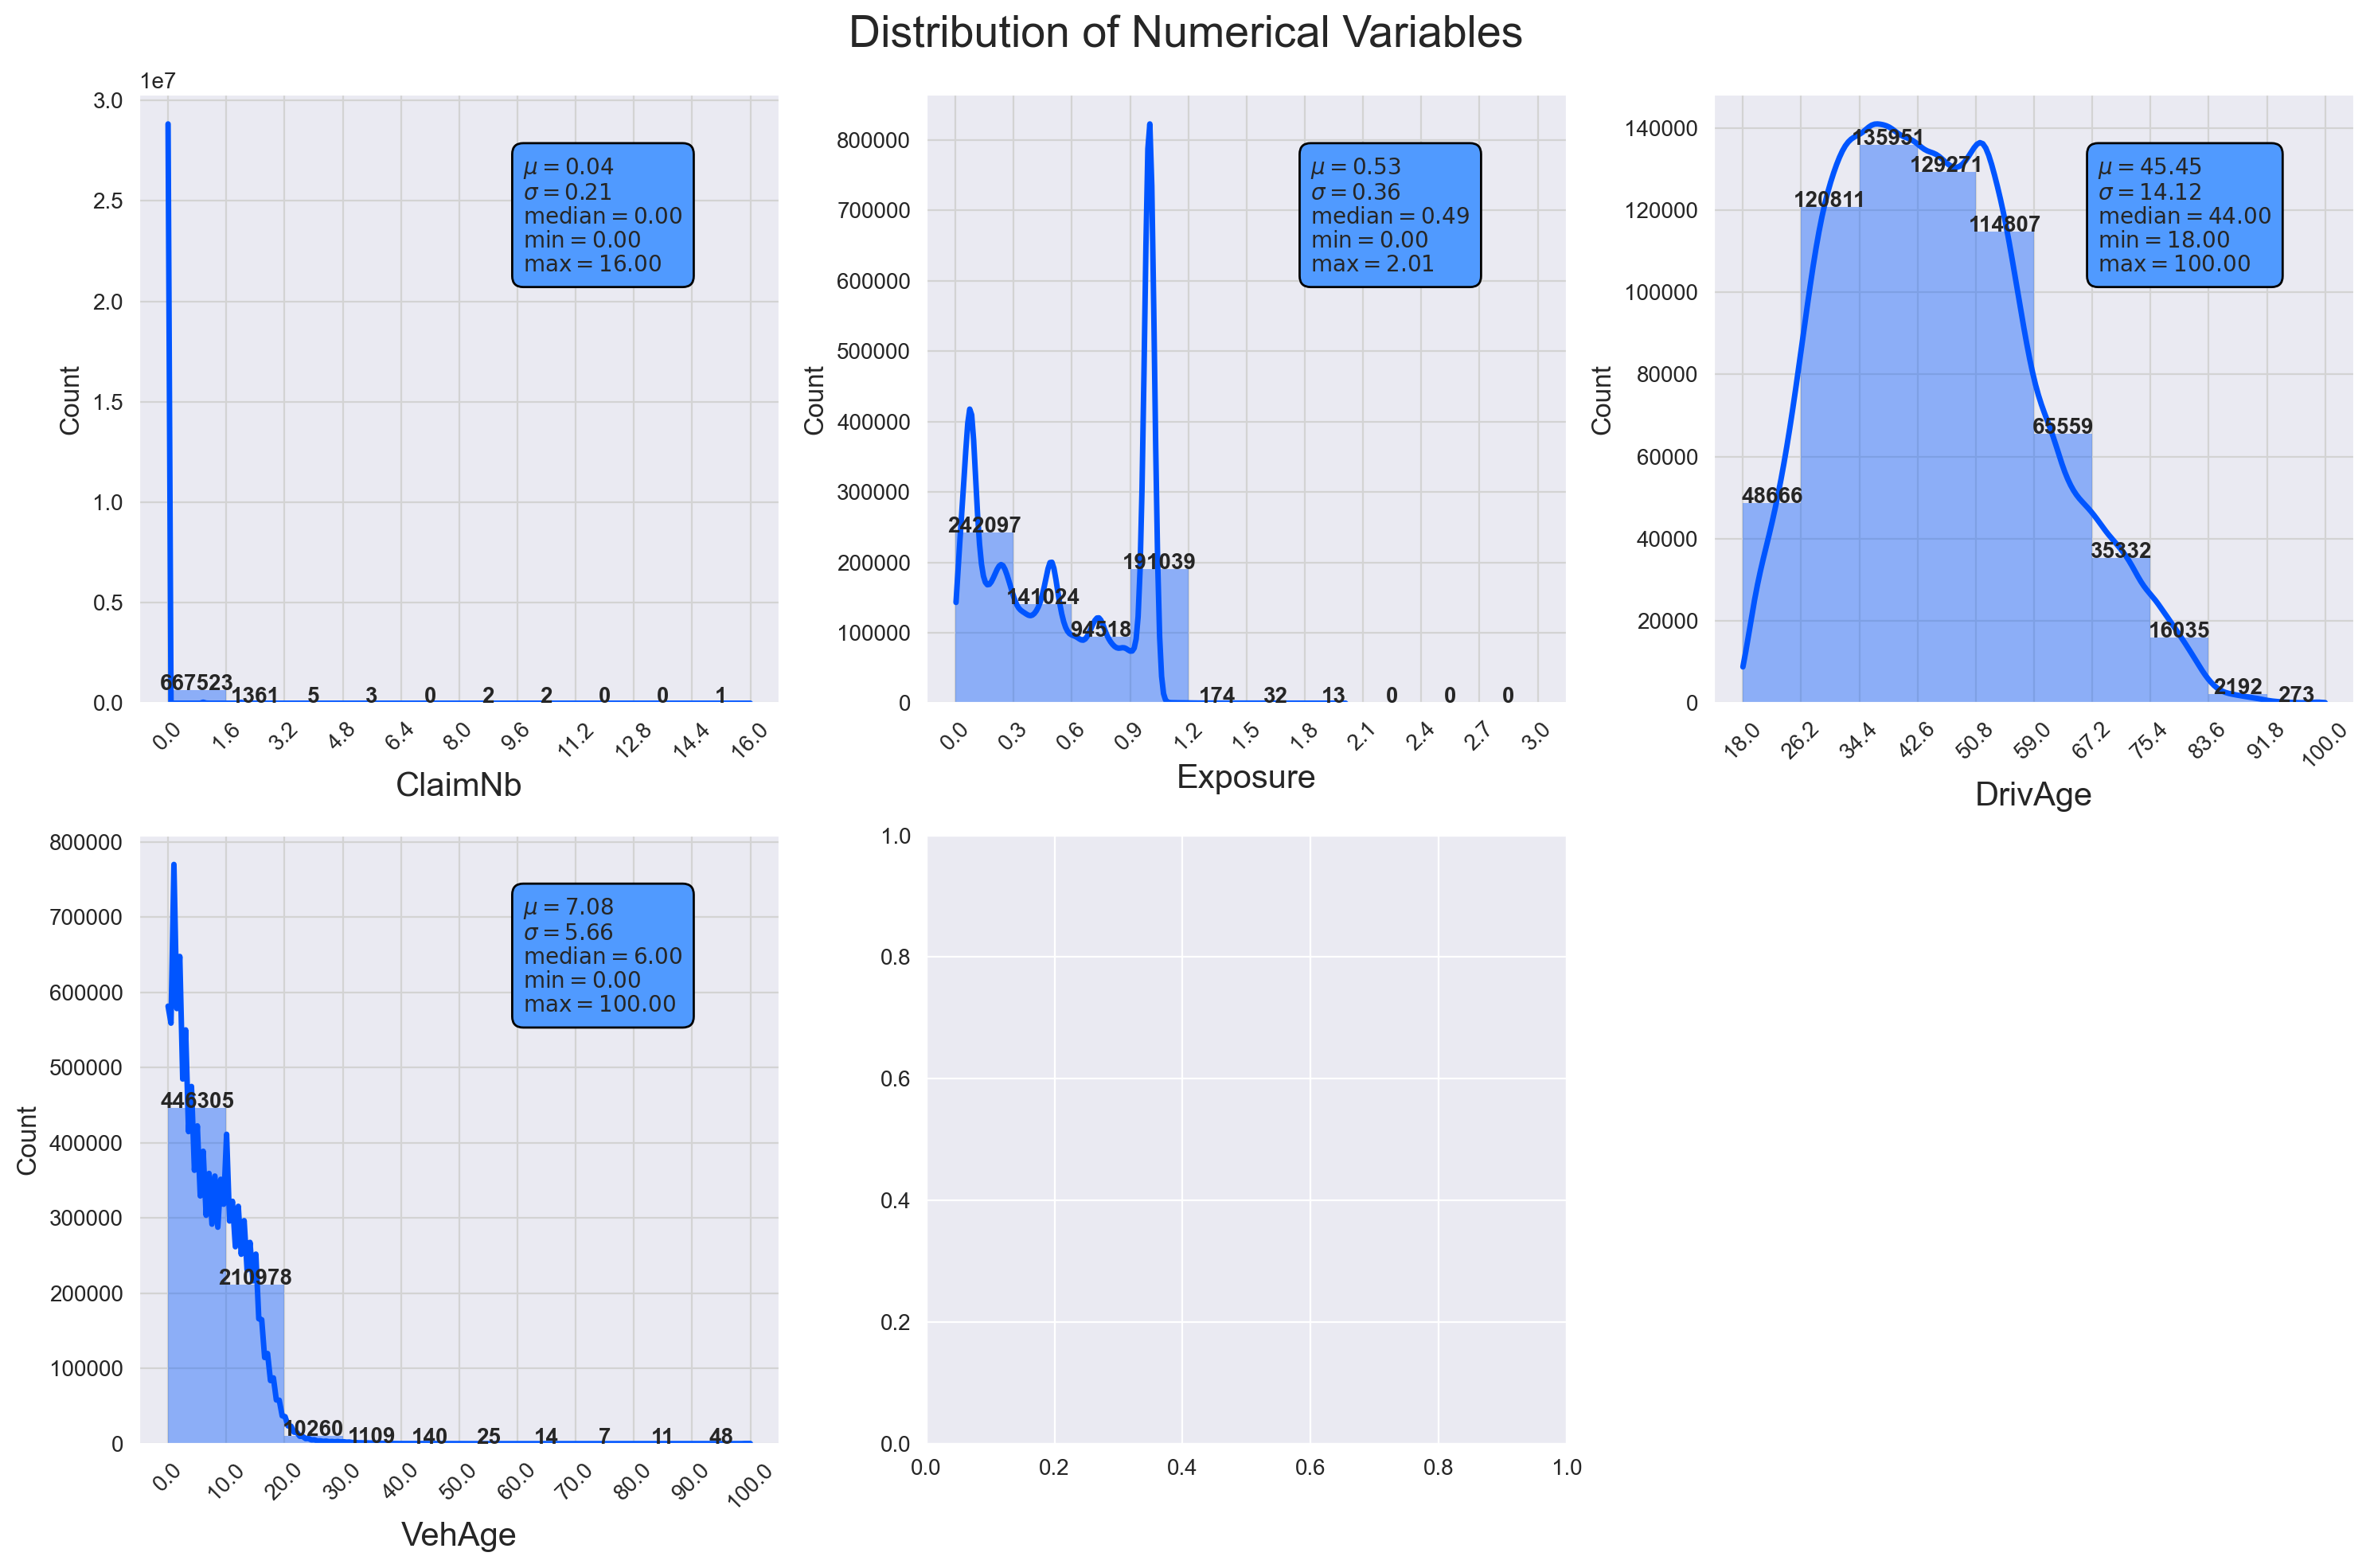

In [333]:
df1 = df.copy()

NumCols = ["ClaimNb", "Exposure", "DrivAge", "VehAge"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]], 
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))                
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.show()

In [342]:
# Poisson distribution looks pretty good! Do more rigorous GOF test
# Then fit conditional expectations

# Is exposure also poisson distributed?

mu_mle = np.mean(df["ClaimNb"])
k = 1
print("Empirical: {}, fitted: {}".format(len(df[df["ClaimNb"] == k])/len(df), scipy.stats.poisson.pmf(k, mu_mle)))

Empirical: 0.03523711423432905, fitted: 0.03800269436250986


In [239]:
# Outlier identification

outlier_indices = []

considered_cols = df.drop(columns=["ClaimNb", "TotalClaimAmount", "Density", "VehBrand", "Region"])

for col in considered_cols:
    ql = df[col].quantile(0.25)
    qu = df[col].quantile(0.75)
    # Inter-quantile range
    iqr = qu - ql
    cutoff_max = qu + (1.5 * iqr)
    cutoff_min = ql - (1.5 * iqr)
    outliers = df[(df[col] < cutoff_min) | (df[col] > cutoff_max)]
    outlier_indices.extend(outliers.index.tolist())
    
outlier_indices = list(set(outlier_indices))
print("{} outliers were identified\n".format(len(outlier_indices)))

97589 outliers were identified



# Define target quantities

In [241]:
target_freq = "ClaimNb"
target_amount = "TotalClaimAmount"

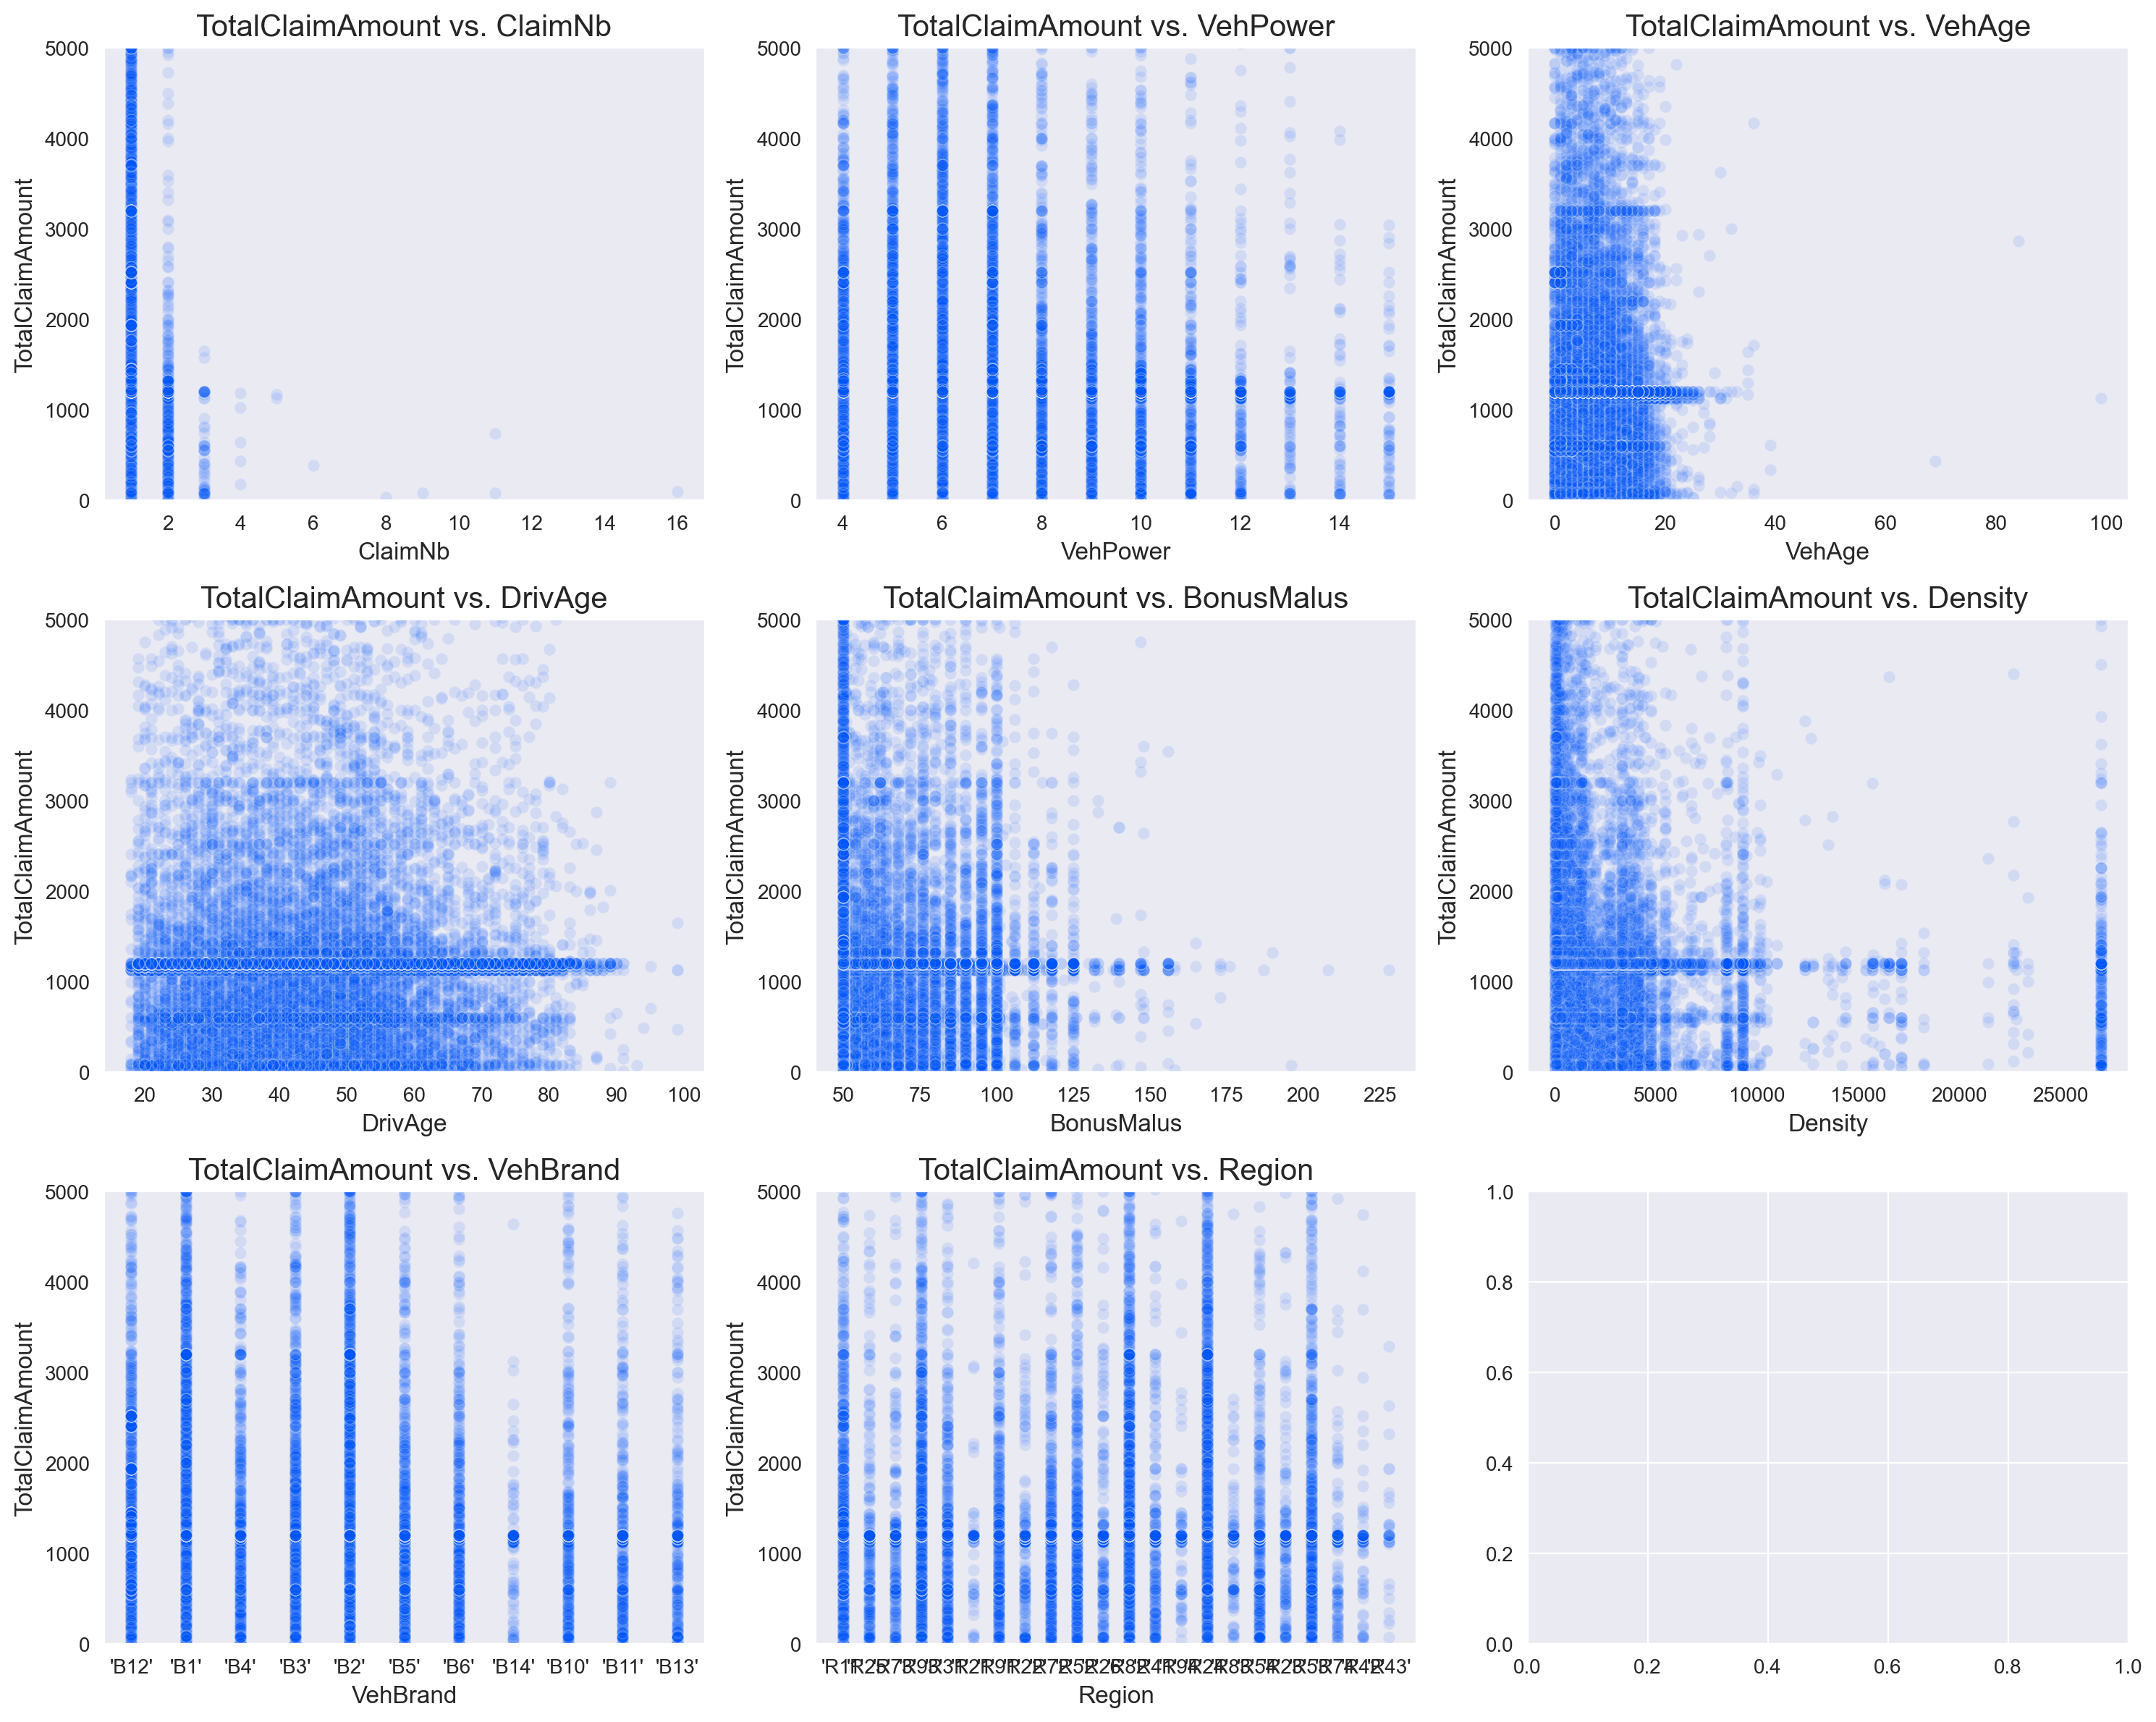

In [247]:
# Outlier removal
# df1 = df.copy()
# df1.drop(outlier_indices, inplace=True)
# df1.reset_index(drop=True, inplace=True)

# filtered_df = df[(df["TotalClaimAmount"] < 50000)]

filtered_df = df[df["ClaimNb"] > 0]

# Plot

# Opacity
alpha = 0.1

features = filtered_df.columns.drop(target_amount)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=filtered_df, x=features[i], y=target_amount, ax=ax[x,y], alpha=alpha)
    ax[x,y].set_title('{} vs. {}'.format(target_amount, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target_amount, size = 12)
    ax[x,y].grid()

    # Limit y-range if needed
    ax[x,y].set_ylim([0, 5000])

plt.tight_layout()
plt.show()

In [156]:
mat_corr = filtered_df.select_dtypes(exclude="object").corr(method="pearson").round(2)
mat_corr

,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,TotalClaimAmount
ClaimNb,1.00,0.00,0.01,-0.00,0.07,0.01,0.08
VehPower,0.00,1.00,-0.01,0.03,-0.08,0.04,0.00
VehAge,0.01,-0.01,1.00,-0.06,0.08,-0.09,0.00
DrivAge,-0.00,0.03,-0.06,1.00,-0.48,-0.00,-0.00
BonusMalus,0.07,-0.08,0.08,-0.48,1.00,0.08,0.01
Density,0.01,0.04,-0.09,-0.00,0.08,1.00,-0.00
TotalClaimAmount,0.08,0.00,0.00,-0.00,0.01,-0.00,1.00


Fit polynomial model with linear regression

In [267]:
# Base data set to use
dataset = filtered_df.select_dtypes(exclude="object")

# Select features
X = dataset[["DrivAge"]]

# Select target
y = dataset["TotalClaimAmount"]

# Polynomial features

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head(5)

,DrivAge,DrivAge^2,DrivAge^3,DrivAge^4,DrivAge^5
0,61.0,3721.0,226981.0,13845841.0,844596301.0
1,50.0,2500.0,125000.0,6250000.0,312500000.0
2,36.0,1296.0,46656.0,1679616.0,60466176.0
3,51.0,2601.0,132651.0,6765201.0,345025251.0
4,45.0,2025.0,91125.0,4100625.0,184528125.0


In [251]:
# Split into test and training sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.3, random_state=0)

In [253]:
# Apply scaler
scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [255]:
# Fit model
linear_reg = LinearRegression()
linear_reg.fit(X_train_poly_scaled, y_train_poly)

LinearRegression()

In [257]:
print("Intercept:{} ".format(linear_reg.intercept_))
for i, coeff in enumerate(linear_reg.coef_):
    print("Coef {}: {}".format(i, coeff))

Intercept:2167.4849650630094 
Coef 0: -287410.67538930994
Coef 1: 1116018.9976269056
Coef 2: -1726019.7420458444
Coef 3: 1239446.4991660265
Coef 4: -343843.88906457246


In [259]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [261]:
model_evaluation(linear_reg, X_train_poly_scaled, y_train_poly, 'Linear Reg.')

,Linear Reg.
MAE,2.308941e+03
MSE,1.101847e+09
RMSE,3.319408e+04
R2-Score,3.567888e-03


C:\Users\marva\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


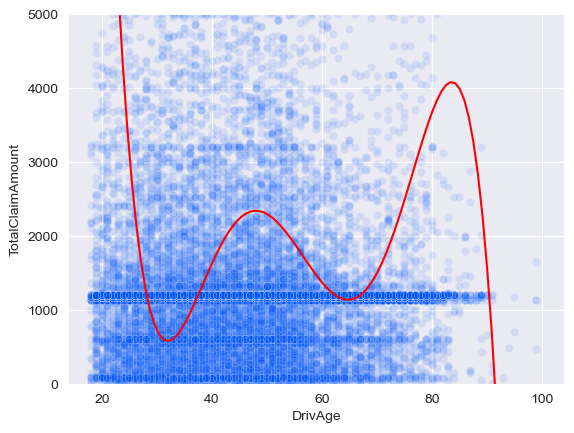

In [265]:
x_plot_data = np.linspace(18, 100, 100).reshape(-1, 1)

x_plot_data_poly = poly_features.fit_transform(x_plot_data)
bla = scaler.transform(x_plot_data_poly)

y_pred = linear_reg.predict(bla)
sns.scatterplot(data=filtered_df, x="DrivAge", y="TotalClaimAmount", alpha=alpha)
ax = plt.gca()
ax.set_ylim([0, 5000])
plt.plot(x_plot_data, y_pred, color="red")
plt.show()

In [1]:
# use a spline wit 4 knots and 3 degrees 
# we combine the spline with a ridge regressions

splt = SplineTransformer(n_knots=5, degree=3)
X_spline = splt.fit_transform(X)
X_spline = pd.DataFrame(X_spline, columns=splt.get_feature_names_out(X.columns))
X_spline.head(5)

NameError: name 'SplineTransformer' is not defined

In [283]:
# Split into test and training sets
X_spline_train, X_spline_test, y_spline_train, y_spline_test = train_test_split(X_spline, y, test_size=0.3, random_state=0)

In [285]:
# Fit model
linear_reg = LinearRegression()
linear_reg.fit(X_spline_train, y_spline_train)

LinearRegression()

In [287]:
print("Intercept:{} ".format(linear_reg.intercept_))
for i, coeff in enumerate(linear_reg.coef_):
    print("Coef {}: {}".format(i, coeff))

Intercept:-710822325654598.2 
Coef 0: 710822325660909.1
Coef 1: 710822325655485.9
Coef 2: 710822325656634.0
Coef 3: 710822325657126.1
Coef 4: 710822325653918.1


In [289]:
model_evaluation(linear_reg, X_spline_test, y_spline_test, 'Spline regression')

,Spline regression
MAE,2.051759e+03
MSE,1.446255e+08
RMSE,1.202603e+04
R2-Score,-9.273906e-03


C:\Users\marva\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


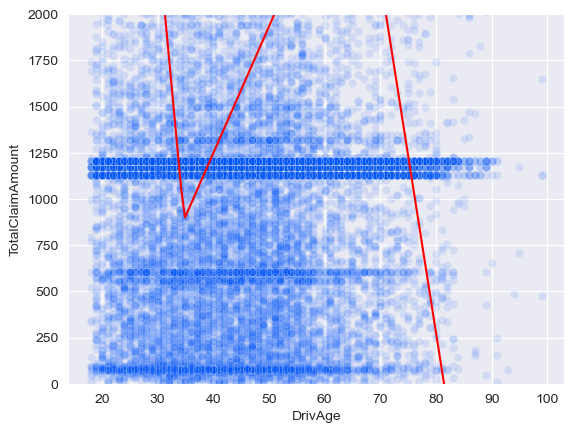

In [291]:
x_plot_data = np.linspace(18, 85, 100).reshape(-1, 1)

x_plot_data_spline = splt.fit_transform(x_plot_data)

y_pred = linear_reg.predict(x_plot_data_spline)
sns.scatterplot(data=filtered_df, x="DrivAge", y="TotalClaimAmount", alpha=alpha)
ax = plt.gca()
ax.set_ylim([0, 2000])
plt.plot(x_plot_data, y_pred, color="red")
plt.show()

In [ ]:
x_plot_data = np.linspace(16, 100, 100).reshape(-1, 1)

x_plot_data_poly = poly_features.fit_transform(x_plot_data)
bla = scaler.transform(x_plot_data_poly)

y_pred = final_model.predict(bla)
sns.scatterplot(data=filtered_df, x="DrivAge", y="TotalClaimAmount", alpha=alpha)
ax = plt.gca()
ax.set_ylim([0, 200])
plt.plot(x_plot_data, y_pred, color="red")
plt.show()